R²: 0.3111906723689658
RMSE: 21.431689285184582
Coefficients: [ 2.23445755e-01  1.94861568e+00 -6.65957779e-02  3.78780779e-01
  1.40452541e-03  2.25557048e-01]
Ridge R²: 0.3111906658603477
Ridge RMSE: 21.431689386439512
Lasso R²: 0.3110648610836737
Lasso RMSE: 21.433646448913187
R²: 0.5050950826851555
RMSE: 18.166354255991603


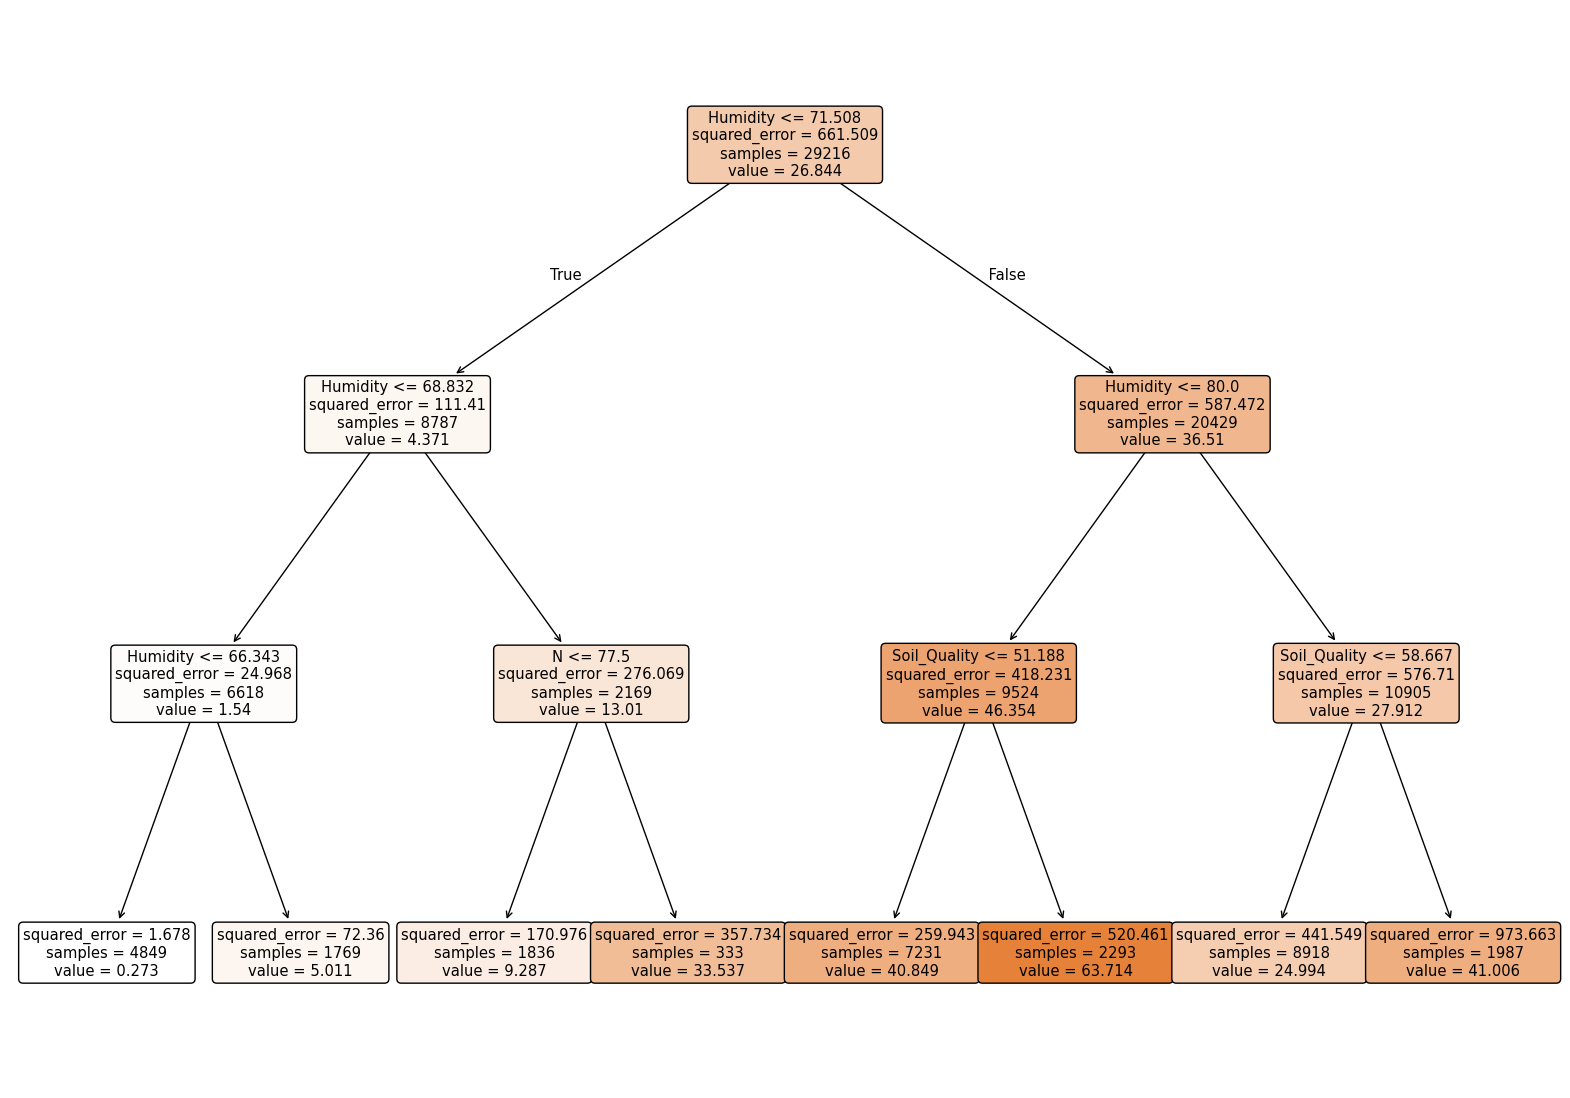

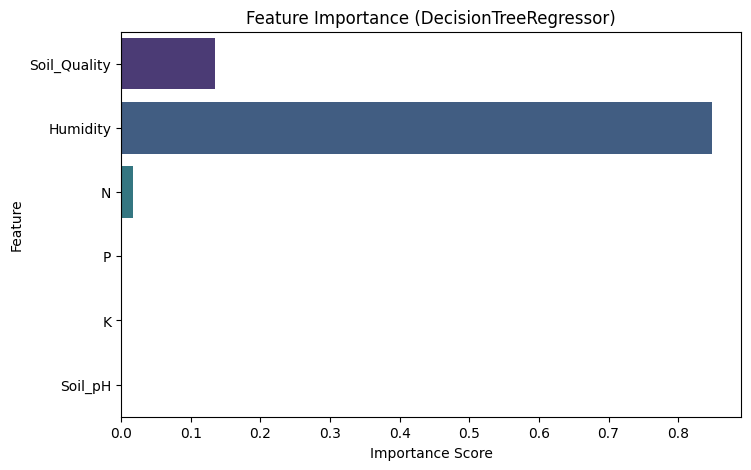

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

ds = pd.read_csv("crop_yield_dataset.csv")
ds["Date"] = pd.to_datetime(ds["Date"])
ds["Year"] = ds["Date"].dt.year
ds["Month"] = ds["Date"].dt.month

crops = ["Tomato", "Wheat", "Corn", "Rice", "Barley", "Soybean", "Cotton", "Sugarcane", "Potato", "Sunflower"]

palette = sns.color_palette("tab10", n_colors=len(crops))

# ----------------------------------------------------------------------------
# Dataset Selection
# ----------------------------------------------------------------------------

# Select features (from EDA results)
X = ds[["Soil_Quality", "Humidity", "N", "P", "K", "Soil_pH"]]
y = ds["Crop_Yield"]

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ----------------------------------------------------------------------------
# Linear Regression
# ----------------------------------------------------------------------------

# Train regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print("R²:", r2_score(y_test, y_pred)) # Measures how well the model explains variation in the data. Low R² means there are other factors not captured by the model (or a lot of randomness).
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred))) # Measures the average prediction error, in the same units as the target
print("Coefficients:", model.coef_) # Each number shows the effect of a 1-unit increase in that feature, while keeping others constant.

#------------------------------------------------------------------------------
# Ridge Regression
# -----------------------------------------------------------------------------

# Linear regression + L2 penalty (shrinks coefficients).
# Good when you have multicollinearity.

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

print("Ridge R²:", r2_score(y_test, y_pred_ridge))
print("Ridge RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_ridge)))

# -----------------------------------------------------------------------------
# Lasso Regression
# -----------------------------------------------------------------------------

# Linear regression + L1 penalty (can shrink some coefficients all the way to 0).
# Good for feature selection — it automatically “drops” unimportant predictors.

lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

print("Lasso R²:", r2_score(y_test, y_pred_lasso))
print("Lasso RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lasso)))

# ------------------------------------------------------------------------------
# DescisionTreeRegressor
# ------------------------------------------------------------------------------

# Train Decision Tree
tree = DecisionTreeRegressor(max_depth=3, random_state=36)  # max_depth controls tree size
tree.fit(X_train, y_train)

# Predictions
y_pred = tree.predict(X_test)

print("R²:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# Plot Tree
plt.figure(figsize=(20, 14))
plot_tree(tree, feature_names=X.columns, filled=True, rounded=True)
plt.show()

# Feature importance values
importances = tree.feature_importances_
features = X.columns

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=features, palette="viridis")
plt.title("Feature Importance (DecisionTreeRegressor)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

# Exporting data from Tree

# print("Features:", tree.tree_.feature)      # indices of features at each split
# print("Thresholds:", tree.tree_.threshold)  # split points
# print("Values:", tree.tree_.value)          # predicted mean at each node

# rules = export_text(tree, feature_names=list(X.columns))
# print(rules)





